<a href="https://colab.research.google.com/github/namoshi/colab/blob/master/%5Bpublished%5D_CelebA_vanilla_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple DCGAN implementation in Keras trained on 64x64 CelebA images

## Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

## Get the data

In [ ]:
!mkdir celeba_gan
!gdown --id 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684 -O celeba_gan/data.zip

Downloading...
From: https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684
To: /content/celeba_gan/data.zip
1.44GB [00:24, 58.1MB/s]


In [ ]:
!unzip -qq celeba_gan/data.zip -d celeba_gan

## Create a `Dataset`

We will work with 64x64 images.

In [ ]:
from tensorflow import keras
dataset = keras.preprocessing.image_dataset_from_directory('celeba_gan', label_mode=None, image_size=(64, 64), batch_size=32)

Found 202599 files belonging to 1 classes.


In [ ]:
dataset = dataset.map(lambda x: x / 255.)

## Display a sample image

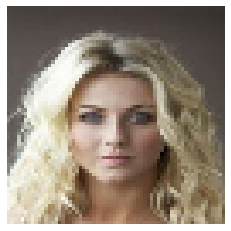

In [ ]:
import matplotlib.pyplot as plt
for x in dataset:
  plt.axis("off")
  plt.imshow((x.numpy() * 255).astype('int32')[0])
  break

## Create the discriminator

It maps a 64x64 image to a binary classification score.

In [ ]:
from tensorflow.keras import layers

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)            

## Create the generator

It mirrors the discriminator, replacing `Conv2D` layers with `Conv2DTranspose` layers.

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape_3 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 64, 64, 512)       20

## Create a GAN model that overrides `train_step`

- We need 2 optimizers, so we also override `compile` to allow that.
- We track our 2 losses with `Mean` metrics. We list them in the `metrics` property so that `fit` will reset the trackers at the start of each epoch.
- The training logic is in `train_step`.

In [ ]:

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')

    @property
    def metrics(self):
      return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}


## Create a callback that periodically saves generated images

In [ ]:

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))


## Train the end-to-end model

In [ ]:
epochs = 100

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/300
6332/6332 [==============================] - 611s 96ms/step - d_loss: 0.5655 - g_loss: 1.7346
Epoch 2/300
6332/6332 [==============================] - 612s 97ms/step - d_loss: 0.6451 - g_loss: 1.1412
Epoch 3/300
6332/6332 [==============================] - 608s 96ms/step - d_loss: 0.6507 - g_loss: 1.0504
Epoch 4/300
6332/6332 [==============================] - 608s 96ms/step - d_loss: 0.6207 - g_loss: 1.1331
Epoch 5/300
6332/6332 [==============================] - 608s 96ms/step - d_loss: 0.6345 - g_loss: 1.0580
Epoch 6/300
6332/6332 [==============================] - 610s 96ms/step - d_loss: 0.6554 - g_loss: 1.0098
Epoch 7/300
6332/6332 [==============================] - 610s 96ms/step - d_loss: 0.6618 - g_loss: 0.9642
Epoch 8/300
6332/6332 [==============================] - 608s 96ms/step - d_loss: 0.6689 - g_loss: 0.9444
Epoch 9/300
6332/6332 [==============================] - 610s 96ms/step - d_loss: 0.6703 - g_loss: 0.9316
Epoch 10/300
6332/6332 [======================

## You end up with images like this after ~30 epochs

![results](https://i.imgur.com/h5MtQZ7l.png)